In [1]:
from typing import Annotated, Literal, TypedDict

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

In [2]:
# langGraph MapReduce imports
import operator
from typing import Annotated, TypedDict, Literal

from langchain_core.pydantic_v1 import BaseModel
from langchain_openai import ChatOpenAI

from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START, MessagesState

In [3]:
import getpass
import os
from dotenv import load_dotenv
os.environ["LANGCHAIN_TRACING_V2"] = "false"
load_dotenv() ## ensure that your .env file in the same directory as this notebook has the OpenAI API Key

True

In [4]:
model = ChatOpenAI(model="gpt-3.5-turbo")


In [5]:
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolInvocation

In [6]:
## setup tool to anomalous traces with their descriptions and connections to initial prompt
@tool
def load_anomolous_traces_v1(query: str): # query may not be necessary, or could be the identifier
    """Inject the anomalous traces and the description of anomaly for hypothesis generation"""
    # In the real implementation, this will not be called at all and will instead
    # be handled via mapreduce faculty over all traces with the explorer multimodal LLM.
    return [
        f"I have evaluated potential anomalies with {query}. Result: the program appears to be stalling when calling the user identity service, as indicated in the figure provided as part of the query."
    ]

tools = [load_anomolous_traces_v1]
tool_node = ToolNode(tools)

In [7]:
## [Optionally] if we were using a human feedback mechanism, this is what we would use
class RequestAnomalyInejection(BaseModel):
    question: str

In [8]:
## now let's bind our tool to the chatbot
model = model.bind_tools(tools)

In [9]:
def should_continue(state: MessagesState) -> Literal["continue", "end"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # [Optionally] If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    # elif last_message.tool_calls[0]["name"] == "AskHuman":
    #     return "ask_human"
    # # Otherwise if there is, we continue
    else:
        return "continue"
        # return "tools"

# Optionally, we define a fake node for prompting human
# def ask_human(state):
#     pass

# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


In [10]:
## build graph

workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("explorer", tool_node)
# workflow.add_node("hypothesizer", )
# [Optionally] workflow.add_node("ask_human", ask_human)


# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")


# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "explorer",
        # We may ask the human [Optionally]
        # "ask_human": "ask_human",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("explorer", "agent")

# optionally After we get back the human response, we go back to the agent
# workflow.add_edge("ask_human", "agent")

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
# We add a breakpoint BEFORE the `ask_human` node so it never executes
# app = workflow.compile(checkpointer=memory, interrupt_before=["ask_human"])


app = workflow.compile(checkpointer=memory)

In [11]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(
    content="Use the load_anomalous_traces tool to find anomalies, then tell me what's going on with our program."
)
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Use the load_anomalous_traces tool to find anomalies, then tell me what's going on with our program.


AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************OWK9. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

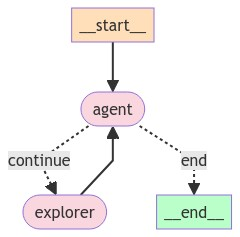

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass